# Présentation de la base de données & Tests de stationnarité


Nous avons exporté les données de l'OCDE dans une base de données que nous avons reformatée, afin d'avoir une indexation multiple au niveau des colonnes : un premier niveau pour les pays et ensuite pour chaque pays les différents indicateurs choisis. Nous avons aussi ajouté des indicateurs concernant les inégalités, à savoir le top 50% du revenu et le top 10% du revenu. Néanmoins nous nous posons quelques questions concernant ces indicateurrs. 1) Le coefficient de Gini est disponible mais le calcul n'est fait que par année (car il nous semble qu'il varie peu). Faut-il alors qu'on le calcule à la main pour chaque trimestre, l'utiliser tel quel (par annnée), ou ne pas l'utiliser du tout? 2) Est-il important de savoir si la part des revenus est bruts ou non, dans le mesure où l'on cherche à évaluer l'impact des politiques fiscales de Trump?

# Partie 1 : Création d'une base de données synthétique pour l'OCDE

In [1]:
import pandas as pd

In [37]:
bottom_50 = pd.read_csv("bottom_50_income.csv",
                       header = 1,
                       sep=';')

In [38]:
top_10 =pd.read_csv(r"top_10_income.csv",
                   header = 1,
                   sep=';')

In [39]:
pays_ocde = {"Germany" :'DEU',"Australia" :'AUS',"Austria":'AUT',"Belgium":'BEL',
             "Canada":'CAN',"Denmark":'DNK',"Spain":'ESP',"Finland":'FIN',
             "France":'FRA',"Greece":'GRC',"Ireland":'IRL',"Italy":'ITA',
             "Japan":'JPN',"Luxembourg":'LUX',"Norway":'NOR',"New-Zealand":'NZL',
             "Netherlands":'NLD',"Portugal":'PRT',"United Kingdom":'GBR',
             "Sweden":'SWE',"Switzerland":'CHE',"Turkey":'TUR',"United-States":'USA'}


df_ocde = pd.read_csv(r"ocde_df")

df_ocde.rename(columns={'Unnamed: 0':'Variables'}, inplace=True)

ind_tuple = list(zip(df_ocde['Pays'], df_ocde['Variables']))
new_index = pd.MultiIndex.from_tuples(ind_tuple, names=["Pays", "Variables"])

# Mise en place du système de double indice

tocde = df_ocde.T.copy()
tocde.columns = new_index
tocde.drop(['Variables', 'Pays'], inplace=True)

# tocde = tocde.drop(['2020-Q1','2020-Q2','2020-Q3','2020-Q4','2021-Q1'])
# On renomme les colonnes de bottom_50 et top_10

bottom_50.columns = ['Variables', 'Year'] + sorted(pays_ocde.keys(), key=str)
top_10.columns = ['Variables', 'Year'] + sorted(pays_ocde.keys(), key=str)

# On prépare bottom_50 pour la fusion

bottom_50 = bottom_50.drop('Variables', axis=1)
for i in range (1,3) : 
    bottom_50 = pd.concat([bottom_50,bottom_50]) 
    
annee = []
for j in range (1,5):
    for i in range (0,29):
        annee.append(str(1991+i)+'-Q'+str(j))
bottom_50['Year'] = annee

# Mise en place double index pour bottom_50 

bottom_50 = bottom_50.set_index('Year')

bottom_50['Variables'] = 'income p0p50'

ind_tuple = list(zip(bottom_50.columns, bottom_50['Variables']))
new_index = pd.MultiIndex.from_tuples(ind_tuple, names=["Pays", "Variables"])
bottom_50.columns = new_index

bottom_50 = bottom_50.drop(('Variables','income p0p50'), axis = 1)

tocde = tocde.merge(right=bottom_50, how='outer',
                    left_index=True,
                    right_index=True).sort_index(axis = 0).sort_index(axis = 1)

# On prépare top_10 pour la fusion

top_10 = top_10.drop('Variables', axis = 1)
for i in range (1,3) : 
    top_10 = pd.concat([top_10,top_10])    
    
annee = []
for j in range (1,5):
    for i in range (0,29):
        annee.append(str(1991+i)+'-Q'+str(j))
top_10['Year'] = annee

# Mise en place double index pour top_10 :
top_10 = top_10.set_index('Year')

top_10['Variables'] = 'income p90p100'

ind_tuple = list(zip(top_10.columns, top_10['Variables']))

new_index = pd.MultiIndex.from_tuples(ind_tuple, names=["Pays", "Variables"])

top_10.columns = new_index

top_10 = top_10.drop(('Variables','income p90p100'), axis=1)

tocde = tocde.merge(right = top_10,
                    how='outer',
                    left_index=True,
                    right_index=True).sort_index(axis = 0).sort_index(axis = 1)

qs = tocde.index.str.replace(r'(Q\d) (\d+)', r'\2-\1')

tocde['date'] = pd.PeriodIndex(qs, freq='Q').to_timestamp()


tocde = tocde.reindex(index=tocde['date'])
tocde = tocde.drop("date", axis=1)
tocde.drop(list(pd.date_range('20200101', periods=5, freq='QS-JAN')), inplace=True)

In [40]:
tocde

Pays       Australia                                                         \
Variables     Actifs  Chomage    Conso  Emplois  Exports Formation      PIB   
date                                                                          
1990-01-01   63.5595  6.23002  108.373  59.5996   26.942    41.272   206.89   
1990-04-01   63.7865  6.46453  108.965  59.6628   26.986    39.657  207.173   
1990-07-01   63.9287  7.22537  109.106  59.3098   28.052    39.505  205.931   
1990-10-01   63.6977  7.86751  108.421  58.6863   28.496    38.098  207.139   
1991-01-01   63.3995  8.73256  108.655  57.8632   29.718    36.525  204.453   
...              ...      ...      ...      ...      ...       ...      ...   
2018-10-01    65.629  5.03693  269.315  62.3233  116.359   113.548  486.394   
2019-01-01   65.6701   5.0256   270.33  62.3697  117.741   112.894  488.812   
2019-04-01   65.9566  5.22984  271.244  62.5071  119.861   111.682  491.985   
2019-07-01   66.0785   5.2299  271.195  62.6227  120.854   112.746  494.974   
2019-10-01   65.9389  5.16322  272.211  62.5343  120.146   112.018  496.921   

Pays                                    Austria  ... United Kingdom  \
Variables  income p0p50 income p90p100   Actifs  ... income p90p100   
date                                             ...                  
1990-01-01          NaN            NaN      NaN  ...            NaN   
1990-04-01          NaN            NaN      NaN  ...            NaN   
1990-07-01          NaN            NaN      NaN  ...            NaN   
1990-10-01          NaN            NaN      NaN  ...            NaN   
1991-01-01       0.2323         0.3281      NaN  ...         0.2593   
...                 ...            ...      ...  ...            ...   
2018-10-01       0.2451         0.3189  61.4248  ...         0.2894   
2019-01-01       0.2448         0.3196  61.5643  ...         0.2884   
2019-04-01       0.2448         0.3196  61.4554  ...         0.2884   
2019-07-01       0.2448         0.3196  61.2008  ...         0.2884   
2019-10-01       0.2448         0.3196  61.2359  ...         0.2884   

Pays       United-States                                                \
Variables         Actifs  Chomage    Conso  Emplois  Exports Formation   
date                                                                     
1990-01-01       66.7333      5.3  5998.06     63.2    682.3   1695.37   
1990-04-01       66.5333  5.33333  6016.33       63  690.785   1668.44   
1990-07-01       66.4667      5.7  6040.16  62.6667  696.014   1659.14   
1990-10-01          66.4  6.13333  5994.21  62.3333  702.143   1628.39   
1991-01-01       66.2333      6.6  5971.67     61.9  706.434   1587.41   
...                  ...      ...      ...      ...      ...       ...   
2018-10-01          62.9  3.83333  13033.4     60.5  2548.79   3983.12   
2019-01-01          63.1  3.86667  13093.2     60.7  2560.41   4020.35   
2019-04-01          62.9  3.66667  13212.8  60.6333  2531.42   4029.71   
2019-07-01       63.1333      3.6  13301.3  60.8333  2536.56   4054.51   
2019-10-01       63.2333      3.6  13353.7  60.9667  2557.85    4075.4   

Pays                                             
Variables       PIB income p0p50 income p90p100  
date                                             
1990-01-01  9358.29          NaN            NaN  
1990-04-01  9392.25          NaN            NaN  
1990-07-01   9398.5          NaN            NaN  
1990-10-01  9312.94          NaN            NaN  
1991-01-01  9269.37       0.2496         0.2931  
...             ...          ...            ...  
2018-10-01  18813.9       0.2368         0.3187  
2019-01-01  18950.3       0.2367         0.3187  
2019-04-01  19020.6       0.2367         0.3187  
2019-07-01  19141.7       0.2367         0.3187  
2019-10-01    19254       0.2367         0.3187  

[120 rows x 207 columns]

*QUESTION* : Que faut-il faire des valeurs manquantes indiquée par NaN? Les remplacer par 0 fausserait les résultalts

Nous allons désormais effectuer des tests de stationnarité sur les différentes variables. Nous appliquons deux tests  : KPSS qui a pour hypothèse nulle H0:"La série est stationnaire" et le test AFD dont l'hypothèse nulle est H0 : "La série est non stationnaire". NB : nous n'avons pas désaisonnalisé les séries avant d'effectuer les tests car nous ne savions pas si cela éait nécessaire.

# Partie 2 : Tests de stationnarité sur différentes séries temporelles

Dans un premier temps nous nous intéressons au PIB des Etats-Unis, puis aux autres séries issues du même pays. Nous nous intéresserons par la suite à quelques données issues d'autres pays de l'OCDE. 

Nous effectuons à chaque fois et alternativement deux tests : **KPSS** et **ADF** (Augmented Dickey-Fuller)

In [24]:
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller

In [73]:
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')
    
def adf_test(series, **kw):    
    statistic, p_value, n_lags, nobs, critical_values, icbest = adfuller(series, **kw)
    # Format Output
    print(f'ADF Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value > 0.05 else ""}stationary')

In [89]:
serie1=tocde['United-States']['PIB']
kpss_test(serie1)

KPSS Statistic: 0.9556147530640225
p-value: 0.01
num lags: 13
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary


C:\Users\Asus\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1843: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
C:\Users\Asus\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1874: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(warn_msg.format(direction="smaller"), InterpolationWarning)


La série n'est pas stationnaire au seuil de 5%, nous allons donc appliquer le test à la série intégrée à l'ordre 1.

In [90]:
serie2 = serie1 - serie1.shift()
serie2.dropna(inplace=True)
kpss_test(serie2)

KPSS Statistic: 0.08667738001103942
p-value: 0.1
num lags: 13
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


C:\Users\Asus\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1876: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(warn_msg.format(direction="greater"), InterpolationWarning)


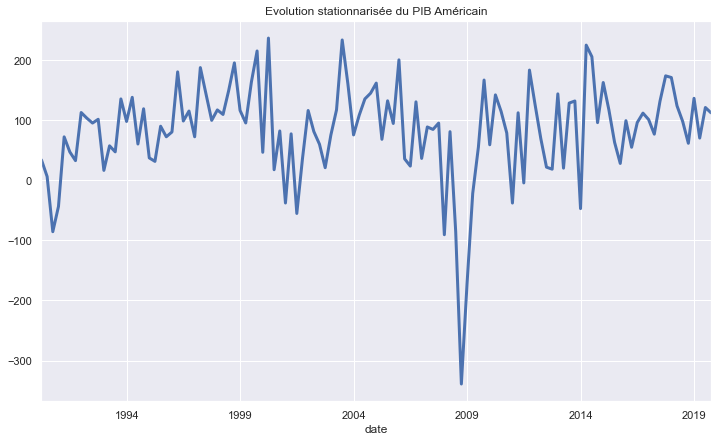

In [94]:
import matplotlib.pyplot as plt 

fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111)

serie2.plot(linewidth=3)

plt.title("Evolution stationnarisée du PIB Américain")
plt.show() 

La série intégrée à l'ordre 1 est stationnaire selon le test KPSS. Maintenant, effectuons le test ADF.

In [76]:
adf_test(serie1)
adf_test(serie2)

ADF Statistic: -0.03066086875171673
p-value: 0.9559218024233861
num lags: 2
Critial Values:
   1% : -3.487517288664615
   5% : -2.8865777180380032
   10% : -2.5801239192052012
Result: The series is not stationary
ADF Statistic: -5.015879029087158
p-value: 2.0642028929741757e-05
num lags: 1
Critial Values:
   1% : -3.487517288664615
   5% : -2.8865777180380032
   10% : -2.5801239192052012
Result: The series is stationary


Comme pour le test KPSS, la série intégrée à l'ordre 1 est stationnaire.
Maintenant effectuons les tests sur le chômage

In [47]:
serie1=tocde['United-States']['Chomage']

In [48]:
kpss_test(serie1)

KPSS Statistic: 0.09403467015765274
p-value: 0.1
num lags: 13
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


C:\Users\Asus\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1843: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
C:\Users\Asus\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1876: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(warn_msg.format(direction="greater"), InterpolationWarning)


In [49]:
adf_test(serie1)

ADF Statistic: -2.2576625816702687
p-value: 0.18598624704216288
num lags: 9
Critial Values:
   1% : -3.4912451337340342
   5% : -2.8881954545454547
   10% : -2.5809876033057852
Result: The series is not stationary


In [50]:
serie2 = serie1 - serie1.shift()
serie2.dropna(inplace=True)

In [51]:
adf_test(serie2)

ADF Statistic: -4.072134155061357
p-value: 0.0010765005911574184
num lags: 7
Critial Values:
   1% : -3.490683082754047
   5% : -2.8879516565798817
   10% : -2.5808574442009578
Result: The series is stationary


La série du chomage des Etats-Unis est stationnaire d'après le test KPSS, nous n'avons pas besoin de l'intégrer à l'ordre 1. Cependant elle n'est pas stationnaire selon le test AFD. Elle est stationnaire selon le test AFD intégrée à l'ordre 1. Maintenant intéressons nous à l'emploi.

In [52]:
serie1=tocde['United-States']['Emplois']

In [53]:
kpss_test(serie1)

KPSS Statistic: 0.562377817476475
p-value: 0.027617608676469594
num lags: 13
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary


C:\Users\Asus\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1843: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)


In [54]:
serie2 = serie1 - serie1.shift()
serie2.dropna(inplace=True)
kpss_test(serie2)

KPSS Statistic: 0.09286187886977079
p-value: 0.1
num lags: 13
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


C:\Users\Asus\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1876: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(warn_msg.format(direction="greater"), InterpolationWarning)


In [55]:
adf_test(serie1)

ADF Statistic: -1.7678060192458818
p-value: 0.3965581385738465
num lags: 3
Critial Values:
   1% : -3.4880216384691867
   5% : -2.8867966864160075
   10% : -2.5802408234244947
Result: The series is not stationary


In [56]:
adf_test(serie2)

ADF Statistic: -3.3324256453449883
p-value: 0.013489819379773064
num lags: 2
Critial Values:
   1% : -3.4880216384691867
   5% : -2.8867966864160075
   10% : -2.5802408234244947
Result: The series is stationary


La série temporelle de l'emploi aux Etats-Unis intégrée à l'ordre 1 est stationnaire selon les test KPSS et AFD.

In [57]:
serie1=tocde['United-States']['Actifs']

In [60]:
kpss_test(serie1)
adf_test(serie1)

serie2 = serie1 - serie1.shift()
serie2.dropna(inplace=True)

kpss_test(serie2)
adf_test(serie2)

KPSS Statistic: 0.7821858654012013
p-value: 0.01
num lags: 13
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary
ADF Statistic: -0.566559878684141
p-value: 0.878360525739549
num lags: 6
Critial Values:
   1% : -3.489589552580676
   5% : -2.887477210140433
   10% : -2.580604145195395
Result: The series is not stationary
KPSS Statistic: 0.173043221208218
p-value: 0.1
num lags: 13
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary
ADF Statistic: -2.680784596659418
p-value: 0.07742280406617921
num lags: 5
Critial Values:
   1% : -3.489589552580676
   5% : -2.887477210140433
   10% : -2.580604145195395
Result: The series is not stationary


C:\Users\Asus\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1843: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
C:\Users\Asus\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1874: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(warn_msg.format(direction="smaller"), InterpolationWarning)
C:\Users\Asus\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1843: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so

La série temporelle des actifs aux Etats-Unis est stationnaire intégrée à l'ordre 1 selon les tests KPSS et ADF.

In [61]:
serie1=tocde['United-States']['Formation']

In [62]:
kpss_test(serie1)
adf_test(serie1)

serie2 = serie1 - serie1.shift()
serie2.dropna(inplace=True)

kpss_test(serie2)
adf_test(serie2)

KPSS Statistic: 0.8792935265198131
p-value: 0.01
num lags: 13
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary
ADF Statistic: -0.6611884906481107
p-value: 0.8565481530480972
num lags: 1
Critial Values:
   1% : -3.4870216863700767
   5% : -2.8863625166643136
   10% : -2.580009026141913
Result: The series is not stationary
KPSS Statistic: 0.07240057002216738
p-value: 0.1
num lags: 13
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary
ADF Statistic: -5.31759978372413
p-value: 5.034243261742464e-06
num lags: 0
Critial Values:
   1% : -3.4870216863700767
   5% : -2.8863625166643136
   10% : -2.580009026141913
Result: The series is stationary


C:\Users\Asus\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1843: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
C:\Users\Asus\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1874: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(warn_msg.format(direction="smaller"), InterpolationWarning)
C:\Users\Asus\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1843: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so

La série temporelle de la formation aux Etats-Unis est stationnaire intégrée à l'ordre 1 selon les tests KPSS et AFD.

In [63]:
serie1=tocde['United-States']['Conso']

kpss_test(serie1)
adf_test(serie1)

serie2 = serie1 - serie1.shift()
serie2.dropna(inplace=True)

kpss_test(serie2)
adf_test(serie2)

KPSS Statistic: 0.9562502354679252
p-value: 0.01
num lags: 13
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary
ADF Statistic: -0.5539760704231023
p-value: 0.8810461846151012
num lags: 4
Critial Values:
   1% : -3.4885349695076844
   5% : -2.887019521656941
   10% : -2.5803597920604915
Result: The series is not stationary
KPSS Statistic: 0.10492181261084312
p-value: 0.1
num lags: 13
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary
ADF Statistic: -3.5762462621917632
p-value: 0.006231727614894671
num lags: 3
Critial Values:
   1% : -3.4885349695076844
   5% : -2.887019521656941
   10% : -2.5803597920604915
Result: The series is stationary


C:\Users\Asus\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1843: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
C:\Users\Asus\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1874: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(warn_msg.format(direction="smaller"), InterpolationWarning)
C:\Users\Asus\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1843: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so

In [64]:
serie1=tocde['United-States']['Exports']

kpss_test(serie1)
adf_test(serie1)

serie2 = serie1 - serie1.shift()
serie2.dropna(inplace=True)

kpss_test(serie2)
adf_test(serie2)

KPSS Statistic: 0.9535354665350328
p-value: 0.01
num lags: 13
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary
ADF Statistic: -0.4153590512020422
p-value: 0.9075026091117948
num lags: 1
Critial Values:
   1% : -3.4870216863700767
   5% : -2.8863625166643136
   10% : -2.580009026141913
Result: The series is not stationary
KPSS Statistic: 0.07461938064884595
p-value: 0.1
num lags: 13
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary
ADF Statistic: -6.404710137541772
p-value: 1.9561891822673754e-08
num lags: 2
Critial Values:
   1% : -3.4880216384691867
   5% : -2.8867966864160075
   10% : -2.5802408234244947
Result: The series is stationary


C:\Users\Asus\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1843: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
C:\Users\Asus\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1874: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(warn_msg.format(direction="smaller"), InterpolationWarning)
C:\Users\Asus\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1843: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so

Les séries des exportations et de la consommation aux Etat-Unis sont stationnaires d'ordre 1. 

In [65]:
serie1=tocde['France']['Exports']

kpss_test(serie1)
adf_test(serie1)

serie2 = serie1 - serie1.shift()
serie2.dropna(inplace=True)

kpss_test(serie2)
adf_test(serie2)

KPSS Statistic: 0.9463214923897139
p-value: 0.01
num lags: 13
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary
ADF Statistic: -0.5964925640167187
p-value: 0.8717725957184033
num lags: 4
Critial Values:
   1% : -3.4885349695076844
   5% : -2.887019521656941
   10% : -2.5803597920604915
Result: The series is not stationary
KPSS Statistic: 0.06908200146357098
p-value: 0.1
num lags: 13
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary
ADF Statistic: -5.784852188149957
p-value: 5.027080364504503e-07
num lags: 3
Critial Values:
   1% : -3.4885349695076844
   5% : -2.887019521656941
   10% : -2.5803597920604915
Result: The series is stationary


C:\Users\Asus\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1843: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
C:\Users\Asus\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1874: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(warn_msg.format(direction="smaller"), InterpolationWarning)
C:\Users\Asus\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1843: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so

In [66]:
serie1=tocde['France']['PIB']

kpss_test(serie1)
adf_test(serie1)

serie2 = serie1 - serie1.shift()
serie2.dropna(inplace=True)

kpss_test(serie2)
adf_test(serie2)

KPSS Statistic: 0.9463167146991861
p-value: 0.01
num lags: 13
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary
ADF Statistic: -0.7398047709641816
p-value: 0.8361681058301751
num lags: 3
Critial Values:
   1% : -3.4880216384691867
   5% : -2.8867966864160075
   10% : -2.5802408234244947
Result: The series is not stationary
KPSS Statistic: 0.10375421602102378
p-value: 0.1
num lags: 13
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary
ADF Statistic: -4.585440042635904
p-value: 0.00013739118891472726
num lags: 2
Critial Values:
   1% : -3.4880216384691867
   5% : -2.8867966864160075
   10% : -2.5802408234244947
Result: The series is stationary


C:\Users\Asus\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1843: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
C:\Users\Asus\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1874: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(warn_msg.format(direction="smaller"), InterpolationWarning)
C:\Users\Asus\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1843: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so

In [67]:
serie1 = tocde['France']['Chomage'].dropna()
serie1

date
2003-01-01    7.93574
2003-04-01    8.09662
2003-07-01    8.01927
2003-10-01    8.34581
2004-01-01    8.52777
               ...   
2018-10-01    8.76056
2019-01-01    8.75797
2019-04-01    8.45035
2019-07-01    8.43242
2019-10-01    8.13304
Name: Chomage, Length: 68, dtype: object

In [68]:
kpss_test(serie1)
adf_test(serie1)

serie2 = serie1 - serie1.shift()
serie2.dropna(inplace=True)

kpss_test(serie2)
adf_test(serie2)

KPSS Statistic: 0.36416619219496654
p-value: 0.09260077922630752
num lags: 11
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary
ADF Statistic: -1.844312301656592
p-value: 0.3586941930018857
num lags: 2
Critial Values:
   1% : -3.5352168748293127
   5% : -2.9071540828402367
   10% : -2.5911025443786984
Result: The series is not stationary
KPSS Statistic: 0.21697730844640392
p-value: 0.1
num lags: 11
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary
ADF Statistic: -3.5439782521371233
p-value: 0.006926916565178634
num lags: 1
Critial Values:
   1% : -3.5352168748293127
   5% : -2.9071540828402367
   10% : -2.5911025443786984
Result: The series is stationary


C:\Users\Asus\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1843: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
C:\Users\Asus\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1843: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
C:\Users\Asus\anaconda3\lib\site-packages\statsmodels\tsa\stat

Nous avons effectué un certain nombre de tests sur les séries. Parfois, les séries n'était stationnaires qu'à l'ordre 1. Dans ce cas la quelle série devons nous utiliser pour la méthode de contrôle synthétique? La série stationnarisée ou la série originale? 